In [1]:
%reset -f

In [2]:
import scipy as sp
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, f_classif, f_regression
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
%matplotlib inline

import utils as ut
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Main area for adding / removing columns and transforming data

In [5]:
def showdistshort(df, cols, threshold=3.5):
    ut.figurefullwidth()
    for i in range(len(cols)):
        ut.subplottitle(i+1,cols[i], w=len(cols))
        sns.distplot(df[cols[i]], bins=20, hist=False)
    
    #print(c,df.shape,"Ouliers", len(outpoints), "{:1.2f}".format(out_per),"%","Nans",nans, "{:1.2f}".format(nan_per),"%","\n")
    plt.show()
    
   
    subplottitle(6, "Outliers", w=6)
    plt.plot(outpoints, 'ro')
    
def showoutliers(df, cols, threshold=3.5):
    ut.figurefullwidth()
    for i in range(len(cols)):
        outliers = mad_based_outlier(df[c].values)
        outpoints = df[c][outliers]
        ut.subplottitle(i+1,cols[i], w=len(cols))
        plt.plot(outpoints,'ro')
    
    #print(c,df.shape,"Ouliers", len(outpoints), "{:1.2f}".format(out_per),"%","Nans",nans, "{:1.2f}".format(nan_per),"%","\n")
    plt.show()
    

## 1) Explore the data. Provide summary statistics and at least three visualizations for the variable columns (one at a time, or in combination). In a brief paragraph, summarize the distributions for variable values and explain your choices for visualization. Are there any anomalous distributions for variables? How did you determine this?


In [65]:


#read in the file
f1 = "/Users/david/data/dataset_challenge_one (6) (1) (1).tsv"
# read csv file into a list, split on commas
contents = [line.strip().split("\t") for line in open(f1)]
variables = contents[0]
contents = contents[1:]
#contents[0]

from numpy import genfromtxt
my_data = genfromtxt(f1, delimiter='\t')
prev_shape = np.shape(my_data)
print(np.shape(my_data), np.shape(variables))
y = my_data[1:,-1]
print(y[:10])
my_data = my_data[1:,:-1]
my_data
x = my_data

ncoords = [n[1] for n in np.argwhere(np.isnan(x))]
ncoords.sort(reverse=True)
print(ncoords)
for n in ncoords:
    x = sp.delete(x, n, 1)
    del variables[n]
print(np.shape(x)[0]-prev_shape[0])
print(np.shape(x))
[n[1] for n in np.argwhere(np.isnan(x))]


(273, 1554) (1554,)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


array([[-0.954246,  0.051024, -0.111203, ..., -0.087631, -0.369153,
         0.153795],
       [ 0.244626, -0.199602, -0.111397, ..., -0.231547, -0.643019,
        -0.014098],
       [ 0.082434, -0.156199, -0.08498 , ..., -0.114298,  0.258495,
        -0.198911],
       ..., 
       [-0.413171,  0.839933,  0.040242, ..., -0.510884,  0.251903,
        -0.822792],
       [ 0.068256,  0.036255, -0.014642, ..., -0.396531,  0.356816,
         0.345088],
       [-0.02935 , -0.260638,  0.039084, ...,  0.794952, -1.089303,
        -0.326193]])

[1289, 74]
-1
(272, 1551)


[]

{0.0: 195, 1.0: 77}

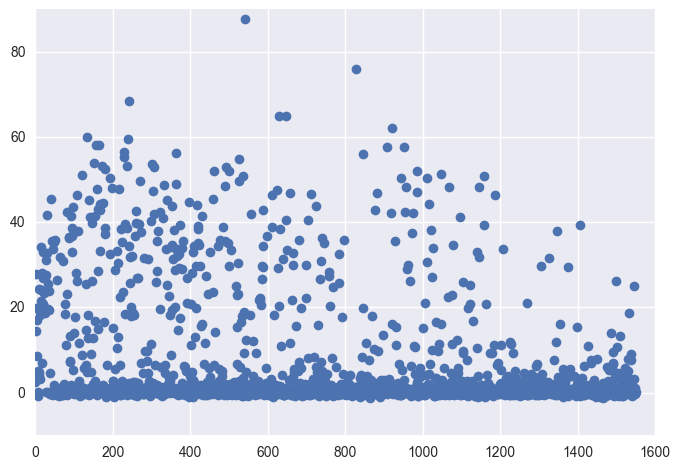

In [68]:
def colstats(vals, c):
    count = len(vals)
    min = np.min(vals)
    max = np.max(vals)
    per_25 = np.percentile(vals, 25)
    mean = np.mean(vals)
    per_75 = np.percentile(vals, 75)
    std = np.std(vals)
    #expected 3
    kurt = sp.stats.kurtosis(vals)
    skew = sp.stats.skew(vals)
    nans = np.isnan(vals).sum()
    per_nans = nans/count * 100
    outliers = mad_based_outlier(vals)
    out_num = len(x[outliers])
    out_per = out_num/count * 100

    d = {"name": c, "count": count, "min": min, "max": max, "per_25": per_25, "mean": mean,
         "per_75": per_75, "std": std, "kurt": kurt, "skew": skew, "nans": nans, 
         "nans_per": per_nans, "out_num": out_num, "out_per": out_per
        }
    
    #st = pd.DataFrame.from_dict(d, orient='index')
    #st.rename(columns={0: c }, inplace=True)
    #st.sort_index(inplace=True)
    return d
def catstats(vals):
    
    unique, counts = np.unique(vals, return_counts=True)
    
  
    d = dict(zip(unique, counts))
    
    return d

dic_list= [colstats(x[:,i], variables[i]) for i in range(x.shape[1])]
catstats(y)

kurt = [d['kurt'] for d in dic_list]
plt.plot(kurt, 'o')
plt.show()

Variable_1 272 Ouliers 36 13.24 % Nans 0 0.00 % 



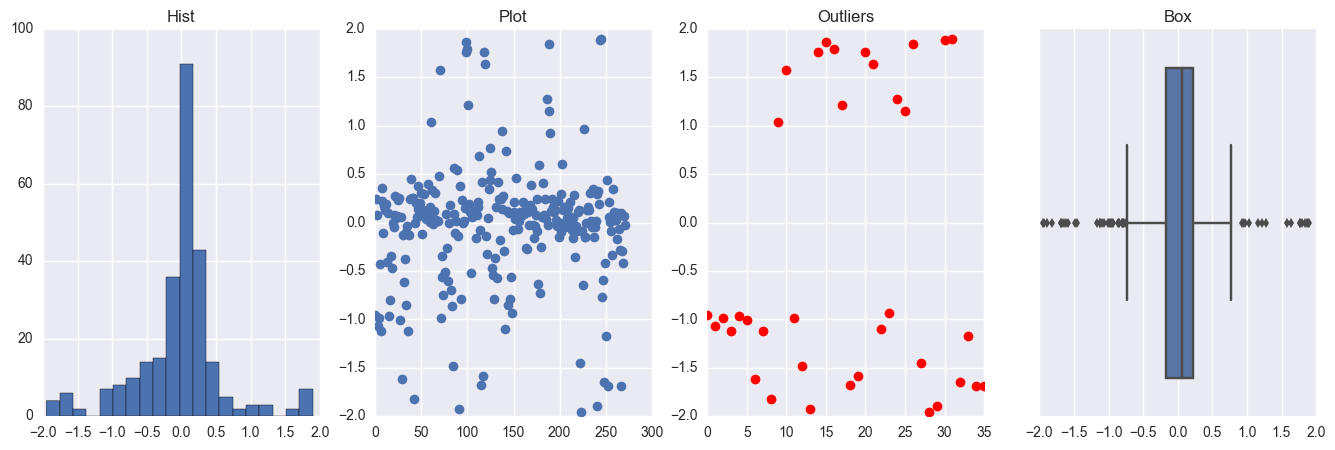

In [73]:
def figurefullwidth():
    plt.figure(figsize=(25,5));
def subplot(n):
    plt.subplot(1,3,n);
def subplottitle(n, title, w=3):
    ax = plt.subplot(1, w, n)
    ax.set_title(title)
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def showdist(xs, c, threshold=3.5):
    figurefullwidth()
    nans = np.isnan(xs).sum()
    vals = xs[~np.isnan(xs)]
    #subplottitle(1, "Nans", w=6)
    #plt.bar([1, 2], [len(xs)-nans,nans], tick_label = ["Ok", "NaN"])
    subplottitle(1, "Hist", w=6)
    plt.hist(vals, bins=20)
    subplottitle(2, "Plot", w=6)
    plt.plot(vals, 'o')
    subplottitle(3, "Outliers", w=6)
    outliers = mad_based_outlier(xs)
    outpoints = xs[outliers]
    plt.plot(outpoints, 'ro')
    subplottitle(4, "Box", w=6)
    sns.boxplot(vals)
    out_per = (len(outpoints)/len(xs))*100
    nan_per = (nans/len(xs))*100
    print(c,len(xs),"Ouliers", len(outpoints), "{:1.2f}".format(out_per),"%","Nans",nans, "{:1.2f}".format(nan_per),"%","\n")
    plt.show()
#print(x[:,0])
showdist(x[:,0], variables[0])

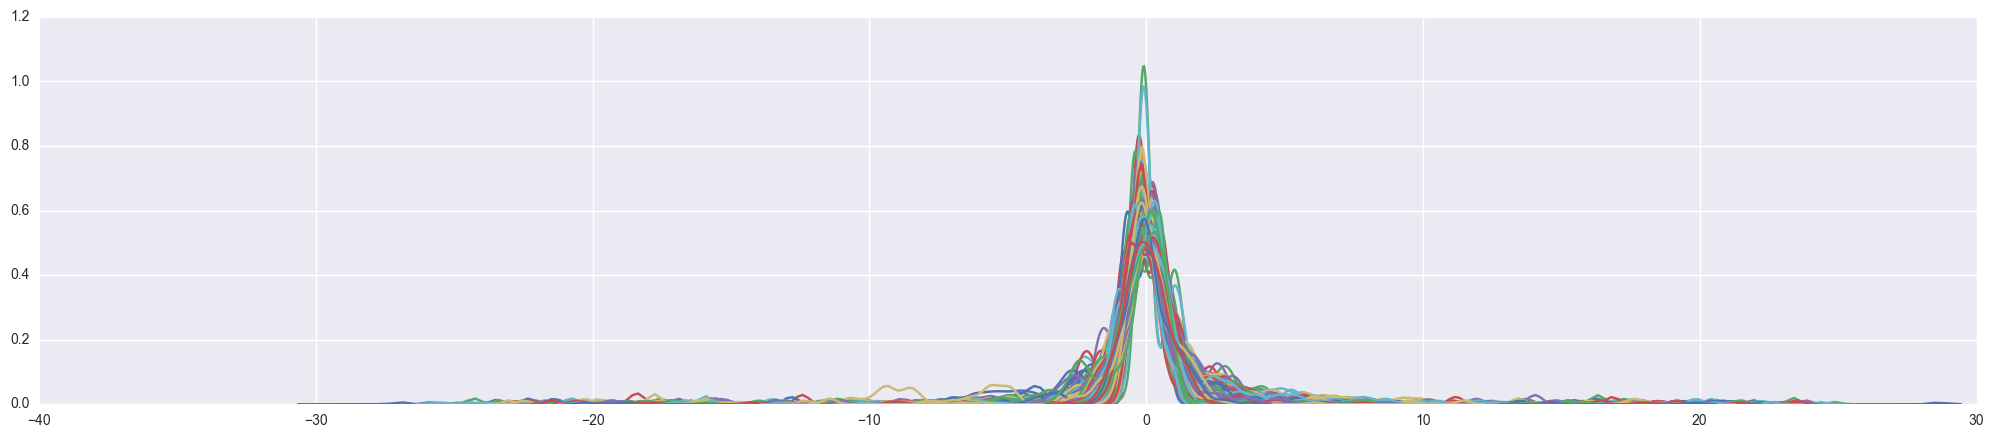

In [74]:
#extract into array
ss = RobustScaler()
xs = ss.fit_transform(x)

# 3 visuals for columns
def showdistcomb(x):
    ut.figurefullwidth()
    for i in range(np.shape(x)[1]):
    #    ut.subplottitle(i+1,cols[i], w=len(cols))
        sns.distplot(x[:,i], bins=20, hist=False)
    
    #print(c,df.shape,"Ouliers", len(outpoints), "{:1.2f}".format(out_per),"%","Nans",nans, "{:1.2f}".format(nan_per),"%","\n")
    plt.show()
showdistcomb(xs)
# summary stats
# anomolous dists? how to determine?

## 2) Present a Principal Components Analysis (PCA) plot for the samples. It should contain a scatterplot of the sample points with the axes PC1 vs. PC2. Indicate on the plot which samples have class = 1 and which have class = 0. 

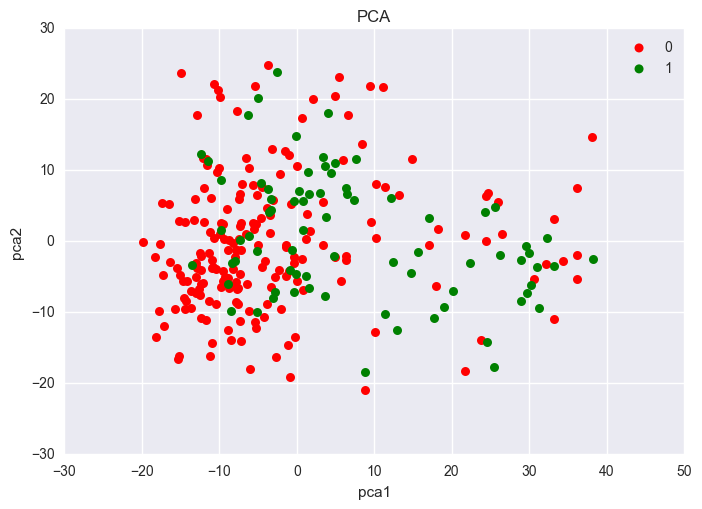

In [79]:
ss = StandardScaler()
xs = ss.fit_transform(x)
pc1 = PCA(n_components=2)
x_pca = pc1.fit_transform(xs)

for col, i, label in zip(["r","g"], [0, 1], [0,1]):
        plt.scatter(x_pca[y==i, 0], x_pca[y==i,1],
                    color=col, lw=2, label=label)
        
#s1 = plt.scatter(x_pca[:,0], x_pca[:,1], c=cl, label=list(cl))
plt.legend(loc='best')
plt.xlabel("pca1")
plt.ylabel("pca2")
plt.title('PCA')

## 3a) Calculate a statistic for every variable that describes its relationship with the class column. Don't list them all, but for the variable column with the most significant statistic, provide a visualization that shows its relationship with class. Include a brief paragraph describing your choices of statistic and visualization.

SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x1111a6048>)

1494 41.749713446 4.81885667037e-10


{'boxes': [<matplotlib.lines.Line2D at 0x1128e44a8>,
 'caps': [<matplotlib.lines.Line2D at 0x1128c5f98>,
 'fliers': [<matplotlib.lines.Line2D at 0x1128d6908>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1128e19e8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1128e4eb8>,
  <matplotlib.lines.Line2D at 0x1128d3b70>]}

([<matplotlib.axis.XTick at 0x11b6c3ac8>,
 <a list of 2 Text xticklabel objects>)

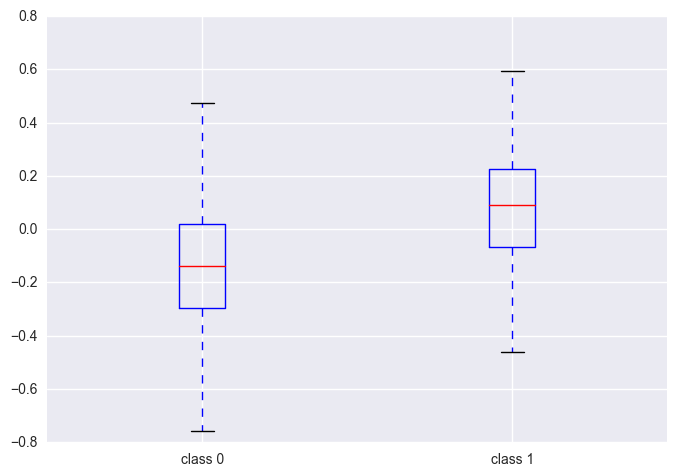

In [80]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(x, y)
pvals = selector.pvalues_
idx = np.argmax(selector.scores_)

d = [x[y==0,1494], x[y==1,1494]]
#d = [x[y==0,0], x[y==1,0]]


print(idx, selector.scores_[1494], selector.pvalues_[1494])
plt.boxplot(d)
plt.xticks([1, 2], ['class 0', 'class 1'])
#plt.scatter(x[:,1494], y)
plt.show()
ut.figurefullwidth()
scores = -np.log10(pvals)
scores /= scores.max()
X_indices = np.arange(x.shape[-1])
#plt.bar(X_indices - .45, scores, width=.2,
#        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

## 3b) Calculate a statistic for every variable that describes its relationship with PC1 (i.e. the first principal component). For the variable with the most significant statistic, provide a visualization that shows its relationship with PC1. Include a brief paragraph describing your choices of statistic and visualization.

SelectPercentile(percentile=10,
         score_func=<function f_regression at 0x1111a61e0>)

1239


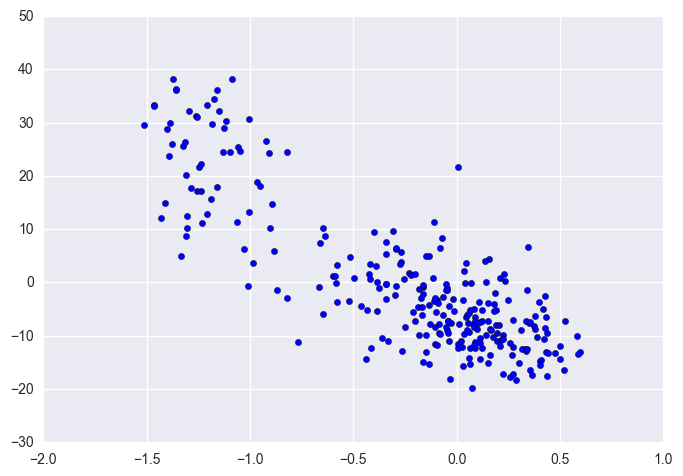

In [81]:
s2 = SelectPercentile(f_regression, percentile=10)
s2.fit(x, x_pca[:,0])
pvals = s2.pvalues_
idx = np.argmax(s2.scores_)

print(idx)
plt.scatter(x[:,1239], x_pca[:,0])
#plt.scatter(x[:,1494], y)
plt.show()
ut.figurefullwidth()
scores = -np.log10(pvals)
scores /= scores.max()
X_indices = np.arange(x.shape[-1])
#plt.bar(X_indices - .45, scores, width=.2,
#        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange')

## 4) Create a classifier model predicting class of each sample using some or all of the variables in the dataset. Use cross-validation to calculate the effectiveness of your classifier. Provide a short paragraph detailing your rationale for picking a classifier method, selecting a subset of variables for the model (if you did this), followed by a summary of your classifier's performance.

In [83]:
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
ss2 = StandardScaler()
se2 = SelectPercentile(f_classif, percentile=100)
pc2 = PCA(n_components=2)
#also look at most_frequent
dummy = DummyClassifier(strategy="stratified")
clf = svm.SVC(kernel='linear', probability=True)
pipe1 = Pipeline([('ss2', ss2), ('pc2',pc2),('se2', se2), ('clf',clf)])
pipe2 = Pipeline([('ss2', ss2), ('pc2',pc2),('se2', se2), ('clf',dummy)])
pipe1_grid = {"clf__kernel": ['linear', 'rbf'],
              "clf__C": [.01, .1, 1],
              "pc2__n_components":[2,5,10, 20, 100],
              #"se2__percentile": [1, 5, 10, 20, 40],
              }
pipe2_grid = {
                "clf__strategy":["stratified","most_frequent"],
                "pc2__n_components":[2,5,10],
              #  "se2__percentile": [1, 5, 10, 20, 40],
              }

#y_pred = cross_val_predict(pipe, x, y, cv=5)
grid1 = GridSearchCV(pipe1, param_grid=pipe1_grid,scoring='neg_log_loss')
grid2 = GridSearchCV(pipe2, param_grid=pipe2_grid,scoring='neg_log_loss')

grid1.fit(x, y)
grid2.fit(x,y)
ms1 = np.array(grid1.cv_results_['mean_test_score'])
ms2 = np.array(grid2.cv_results_['mean_test_score'])
grid1.best_params_
grid2.best_params_
#grid1.best_estimator_
ms1.mean()
ms2.mean()
#cm = confusion_matrix(y, y_pred, labels=[0,1])

#ut.plot_catmatrix(cm, [0, 1], [0, 1], x_title ="predicted", y_title="true")
#precision_recall_fscore_support(y, y_pred, average='macro')
#print(classification_report(y, y_pred))


#compare to baseline



GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('ss2', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pc2', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('se2', SelectPercentile(percentile=100,
         score_func=<function f_classif at 0x1111a6048>)),...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__kernel': ['linear', 'rbf'], 'pc2__n_components': [2, 5, 10, 20, 100], 'clf__C': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('ss2', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pc2', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('se2', SelectPercentile(percentile=100,
         score_func=<function f_classif at 0x1111a6048>)), ('clf', DummyClassifier(constant=None, random_state=None, strategy='stratified'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pc2__n_components': [2, 5, 10], 'clf__strategy': ['stratified', 'most_frequent']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

{'clf__C': 0.01, 'clf__kernel': 'linear', 'pc2__n_components': 20}

{'clf__strategy': 'most_frequent', 'pc2__n_components': 2}

-0.58401563079365537

-12.25364677245912